### Proposals for a 'zero carbon' future

... with some back of the envelope calculations...

This analysis uses the 2018 Transportation survey.

View the survey instrument: https://static1.squarespace.com/static/5b63672bcef372eea958d8a5/t/5c059d9c4fa51ac0d9435219/1543871900238/Commuting-2018-Survey.pdf

In [1]:
%config Completer.use_jedi = False # autocomplete

from datetime import timedelta, date

import geopandas as gpd
import numpy as np
import pandas as pd
import scipy.stats as stats
from tabulate import tabulate # for printing out tabular results

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


GEOID = 'GEOID' # blockgroup

SURVEY18_FILEPATH =  '../data/private/transportation_survey/2018TR.csv'
SURVEY18_CODEBOOK_FILEPATH = '../data/private/transportation_survey/2018TR_Codebook.xlsx'

## Load in the transportation survey data and the codebook that describes the data

In [4]:
survey18_df = pd.read_csv(SURVEY18_FILEPATH,
                          dtype={'E_Age':'str', GEOID: 'str'}, # for easier merging  with shapefile
                          na_values=' ')
assert(survey18_df['Year'].unique() == [2018])
columns = list(survey18_df.columns)
print('%s columns'%len(columns))

142 columns


/Users/aberke/projects/CS_MITOS/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (10,41,72,73,74,75,76,79,80,81,86,92,93,94,95,96,98,99,100,101,106) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
survey18_codebook = pd.read_excel(SURVEY18_CODEBOOK_FILEPATH, header=1).set_index('Variable')
print('codebook columns:',list(survey18_codebook.columns))
# survey18_codebook[['Label','Measurement Level']].head()

codebook columns: ['Position', 'Label', 'Measurement Level', 'Role', 'Column Width', 'Alignment', 'Print Format', 'Write Format']


### Shapefile
Load in the shapefile(s) and merge geographic information with survey information.

,COUNTYFP,TRACTCE,distance to MIT (miles),driving distance to MIT (miles),geometry
GEOID,,,,,
250277304011,027,730401,35.421511,40.303552,"POLYGON ((-71.78563 42.30372, -71.78547 42.303..."
250277304014,027,730401,35.034617,39.689265,"POLYGON ((-71.77701 42.30069, -71.77698 42.300..."


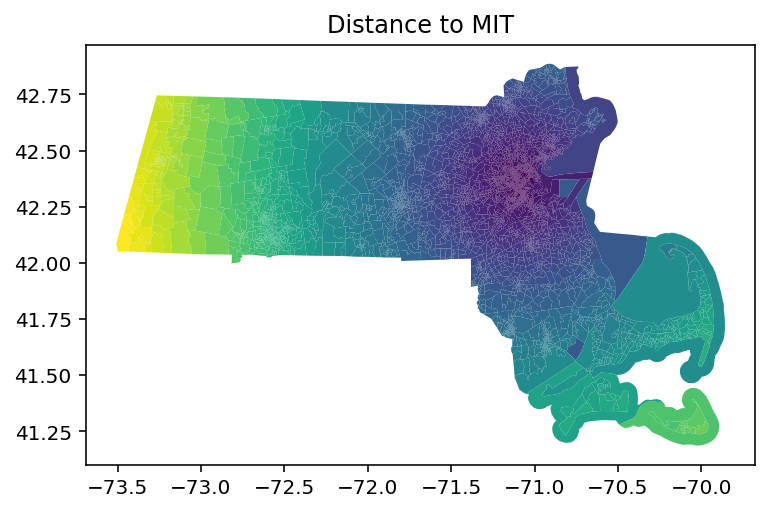

In [3]:
bg_shapes_filepath = '../data/public/shapes_25_bg'
bg = gpd.read_file(bg_shapes_filepath).set_index('GEOID')
bg.columns = [
    'COUNTYFP',
    'TRACTCE',
    'distance to MIT (miles)',
    'driving distance to MIT (miles)',
    'geometry']
bg.plot(column='distance to MIT (miles)')
plt.title('Distance to MIT')
bg.head(2)

In [5]:
# merge the survey data with  the shapefile
survey18_df = survey18_df.merge(bg, on=GEOID)

## Mode miles per day

Get baseline estimates for miles/day for each of the following vehicle modes


In [89]:
# these are the variables I need
ACADEMIC_GROUP = 'TYPE_NUM' # weight by academic group response rate

DRIVING_DIST = 'driving distance to MIT (miles)' # can also use a PT dist?
PRIMARY_COMMUTE_MODE = 'Q95_16_summary'

# 'week_1', ...'week_5' in response to the question 
# "Please indicate how you commuted TO CAMPUS each day LAST WEEK."
# Please make one entry for each day of the week.
week_day_qs = [
    'week_1',
    'week_2',
    'week_3',
    'week_4',
    'week_5'
]
# only asked if Q61: In the last year, have you driven to campus for work or study? = Yes
# What type of vehicle do you typically use to drive to campus?
VEHICLE_TYPE = 'Q68'

# Q61: In the last year, have you driven to campus for work or study?
DRIVEN = 'Q61'

# variables created
WEIGHT = 'weight' # inverse of academic group response rate
# each mode will be a column. 0 if not primary commute mode, 1 otherwise
COMMUTE_DAYS_PER_WEEK_WEIGHT = 'commute days/week weight' # days commute / 5
VEHICLE = 'vehicle'

In [90]:
for q in [PRIMARY_COMMUTE_MODE, VEHICLE_TYPE, DRIVEN]+week_day_qs:
    print(q, survey18_codebook.loc[q]['Label'][0])

Q95_16_summary Primary Commute Method
Q68 What type of vehicle do you typically use to drive to campus? - Selected Choice
Q61 In the last year, have you driven to campus for work or study?
week_1 Please make one entry for each day of the week. - Monday
week_2 Please make one entry for each day of the week. - Tuesday
week_3 Please make one entry for each day of the week. - Wednesday
week_4 Please make one entry for each day of the week. - Thursday
week_5 Please make one entry for each day of the week. - Friday


In [91]:
completions_df = survey18_df.loc[survey18_df[
    survey18_df[DRIVEN].notnull() & \
    survey18_df[week_day_qs].notnull().all(axis=1) & \
    survey18_df[PRIMARY_COMMUTE_MODE]
].index]
completions_n = len(completions_df)
print('%s / %s completion criteria met'%(completions_n, len(survey18_df)))
print('response rate = %.02f'%((completions_n/len(survey18_df))))

9127 / 20077 completion criteria met
response rate = 0.45


calculate weights by academic group response rate

In [92]:
academic_groups = survey18_df.groupby(ACADEMIC_GROUP).count()['PID'].rename('N').to_frame()
academic_groups['sample'] = completions_df.groupby(ACADEMIC_GROUP).count()['PID']
academic_groups['response rate'] = academic_groups['sample']/academic_groups['N']
academic_groups[WEIGHT] = academic_groups['N']/academic_groups['sample']
academic_groups

,N,sample,response rate,weight
TYPE_NUM,,,,
Administrative Staff,2719,1974,0.726002,1.377406
Faculty,998,438,0.438878,2.278539
Graduate Student,6187,2436,0.393729,2.539819
Other Academic Group,2196,912,0.415301,2.407895
Service Staff,691,101,0.146165,6.841584
Sponsored Research Staff,1494,844,0.564926,1.770142
Support Staff,1391,910,0.654206,1.528571
Undergraduate Student,4401,1512,0.343558,2.910714


In [93]:
mode_miles_df = completions_df[
    [ACADEMIC_GROUP, DRIVING_DIST, PRIMARY_COMMUTE_MODE, VEHICLE_TYPE] + week_day_qs
].copy()
mode_miles_df[WEIGHT] = mode_miles_df[ACADEMIC_GROUP].map(academic_groups[WEIGHT])
mode_miles_df.head(2)

,TYPE_NUM,driving distance to MIT (miles),Q95_16_summary,Q68,week_1,week_2,week_3,week_4,week_5,weight
1,Administrative Staff,6.412238,Take public transportation (4 items),Gas/diesel vehicle,Worked at home or other remote location,"Walked, then took public transportation","Walked, then took public transportation",Worked at home or other remote location,Worked at home or other remote location,1.377406
3,Sponsored Research Staff,6.412238,Take public transportation (4 items),NaN,Worked at home or other remote location,"Walked, then took public transportation","Walked, then took public transportation","Walked, then took public transportation","Walked, then took public transportation",1.770142


Set commute days/week weight

In [94]:
# compute commute days per week weight

#  Responses with no commute
week_day_resp_no_commute = [
    'Out of office (e.g., sick, vacation, jury duty, business trip)',
    'Worked at home or other remote location',
    'Scheduled day off (e.g., weekend)',
    np.nan,
]

def commuter_days_weight(row):
    """Returns the fraction of weekdays the person did commute."""
    assert(5 == len(week_day_qs))
    return (5 - row[week_day_qs].isin(week_day_resp_no_commute).sum())/5

mode_miles_df[COMMUTE_DAYS_PER_WEEK_WEIGHT] = mode_miles_df.apply(commuter_days_weight, axis=1)

Set vehicle

None if commuter does not drive

In [95]:
print(mode_miles_df[VEHICLE_TYPE].value_counts())

Gas/diesel vehicle                                     2993
Hybrid vehicle                                          245
Plug-in electric vehicle (including plug-in hybrid)      87
Motorcycle                                               26
Other                                                    17
Name: Q68, dtype: int64


In [54]:
vehicle_types = [
    'Gas/diesel vehicle', 'Hybrid vehicle', 
    'Plug-in electric vehicle (including plug-in hybrid)', 'Motorcycle'
]
DEFAULT_VEHICLE_TYPE = 'Gas/diesel vehicle'

In [96]:
def get_vehicle(row):
    if row[PRIMARY_COMMUTE_MODE] != 'Drive alone the entire way':
        return None
    if row[VEHICLE_TYPE] in vehicle_types:
        return row[VEHICLE_TYPE]
    # default to gas: applies to responses 'nan' and 'Other'
    return DEFAULT_VEHICLE_TYPE

In [97]:
mode_miles_df[VEHICLE] = mode_miles_df.apply(get_vehicle, axis=1)

A display of the variables we will use for the computation:

In [98]:
mode_miles_df[[
    ACADEMIC_GROUP, WEIGHT, VEHICLE, COMMUTE_DAYS_PER_WEEK_WEIGHT, DRIVING_DIST
]].head()

,TYPE_NUM,weight,vehicle,commute days/week weight,driving distance to MIT (miles)
1,Administrative Staff,1.377406,None,0.4,6.412238
3,Sponsored Research Staff,1.770142,None,0.8,6.412238
5,Administrative Staff,1.377406,Gas/diesel vehicle,1.0,17.619534
7,Administrative Staff,1.377406,Gas/diesel vehicle,0.8,6.391546
8,Support Staff,1.528571,None,1.0,6.391546


In [99]:
def get_weighted_avg_daily_miles(row):
    return row[WEIGHT] * row[COMMUTE_DAYS_PER_WEEK_WEIGHT] * row[DRIVING_DIST]

avg_daily_miles = []
for v in vehicle_types:
    v_df = mode_miles_df[mode_miles_df[VEHICLE]==v]
    avg_daily_miles += [v_df.apply(get_weighted_avg_daily_miles, axis=1).sum()]

vehicle_avg_daily_miles_df = pd.DataFrame({
    VEHICLE: vehicle_types, 
    'avg miles/day': avg_daily_miles}
).set_index(VEHICLE)

In [100]:
vehicle_avg_daily_miles_df

,avg miles/day
vehicle,
Gas/diesel vehicle,25762.441194
Hybrid vehicle,1650.112929
Plug-in electric vehicle (including plug-in hybrid),672.298010
Motorcycle,465.590967


What's going on with the motorcycle miles?

Answer: a disproportionate number of the motorcycle riders are service staff, and service staff had a low response rate and therefore a higher weighting. I wonder if we want to include motorcycles or not in this analysis.

In [88]:
mode_miles_df[mode_miles_df[VEHICLE]=='Motorcycle'][[
    ACADEMIC_GROUP, WEIGHT, VEHICLE, COMMUTE_DAYS_PER_WEEK_WEIGHT, DRIVING_DIST
]]

,TYPE_NUM,WEIGHT,vehicle,commute days/week weight,driving distance to MIT (miles)
630,Support Staff,1.528571,Motorcycle,1.0,3.260023
9434,Undergraduate Student,2.910714,Motorcycle,0.6,1.028866
10195,Undergraduate Student,2.910714,Motorcycle,1.0,1.116479
11651,Sponsored Research Staff,1.770142,Motorcycle,0.8,9.204555
15376,Service Staff,6.841584,Motorcycle,1.0,11.780821
15745,Service Staff,6.841584,Motorcycle,1.0,9.680463
17949,Undergraduate Student,2.910714,Motorcycle,1.0,1.314324
18379,Administrative Staff,1.377406,Motorcycle,0.2,7.071575
19587,Service Staff,6.841584,Motorcycle,0.6,20.129189
19731,Sponsored Research Staff,1.770142,Motorcycle,1.0,18.240967
